# Прогноз цен на карбамид и аммиак 2021-2050

Импортируем необходимые для анализа и визуализации библиотеки

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D

Cчитаем excel файл, прикрепеленный в приложении

In [8]:
data = pd.read_excel('Kearney_case.xlsx')
data = data[:-1]

Переформатируем столбец с цен на природный газ, чтобы в не остались только значения

In [9]:
data['LNG price'] = data['LNG price'].apply(lambda x: float(x.split(',')[1]))

In [10]:
data

,Date,LNG price,Oil price,Urea price
0,Jan 1997,5.43,24.15,173.50
1,Feb 1997,2.95,20.30,160.38
2,Mar 1997,3.05,20.41,148.00
3,Apr 1997,3.57,20.21,135.00
4,May 1997,3.69,20.88,113.13
...,...,...,...,...
284,Sep 2020,1.69,40.22,250.50
285,Oct 2020,3.08,35.79,245.00
286,Nov 2020,2.94,45.34,245.00
287,Dec 2020,2.40,48.52,245.00


На диаграмме рассеяния покажем зависимость между ценой на нефть и ценой на карбамид (1997 - 2021 гг.)

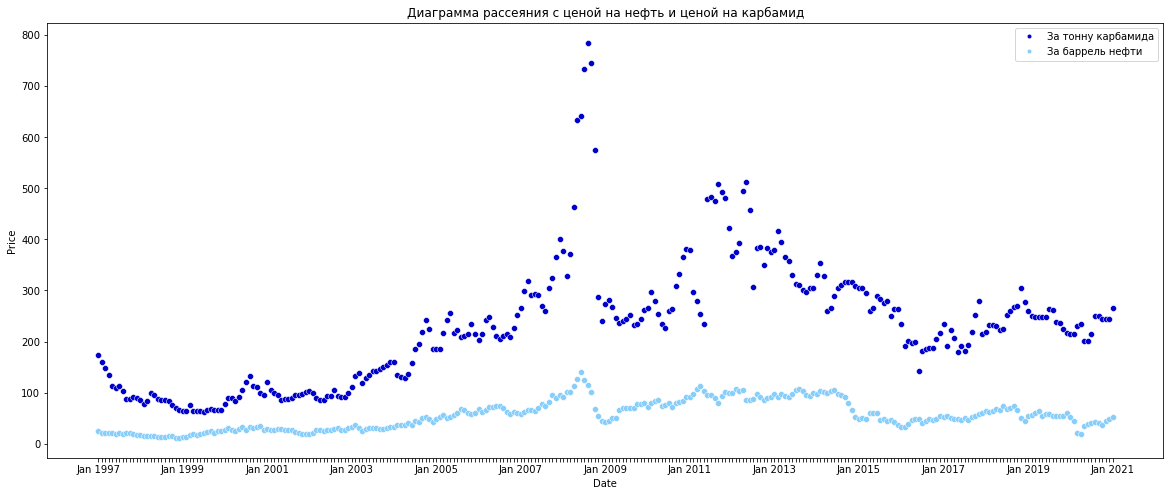

In [11]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.title('Диаграмма рассеяния с ценой на нефть и ценой на карбамид')
sns.scatterplot(x='Date', y='Urea price',  data=data, color='mediumblue')
sns.scatterplot(x='Date', y='Oil price',  data=data, color='lightskyblue')

every_nth = 24
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.xlabel('Date')
plt.ylabel('Price')
custom = [Line2D([], [], marker='.', color='mediumblue', linestyle='None'),
          Line2D([], [], marker='.', color='lightskyblue', linestyle='None')]
plt.legend(custom, ['За тонну карбамида', 'За баррель нефти'], loc='upper right')

plt.show()

Удалим столбец-признак "Дата", чтобы он не влиял на обучение модели

In [12]:
data = data.drop('Date', axis=1)
data

,LNG price,Oil price,Urea price
0,5.43,24.15,173.50
1,2.95,20.30,160.38
2,3.05,20.41,148.00
3,3.57,20.21,135.00
4,3.69,20.88,113.13
...,...,...,...
284,1.69,40.22,250.50
285,3.08,35.79,245.00
286,2.94,45.34,245.00
287,2.40,48.52,245.00


Покажем на матрице корреляций зависимость между признаками

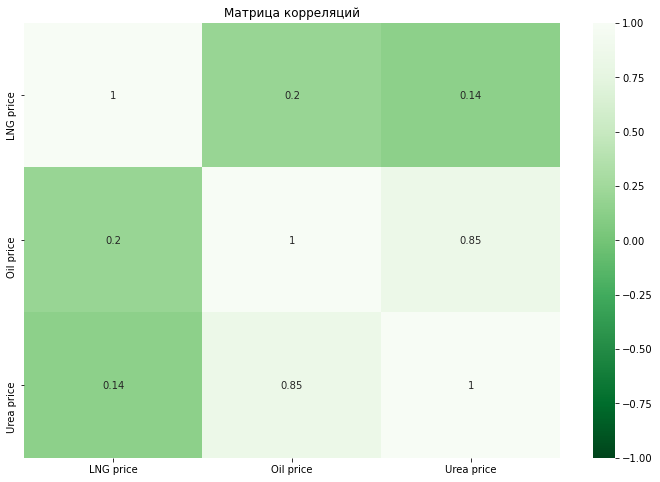

In [13]:
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='Greens_r')
heatmap.set_title('Матрица корреляций');

Введем матрицу объект-признак X и целевую переменную y

In [16]:
y = data['Urea price']
X = data[['LNG price', 'Oil price']]

Разделим выборку на обучающую и тестовую и нормализуем признаки

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=21)

normalizer = preprocessing.StandardScaler()

X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

Обучим модель и посчитаем MSE и R-square для полученных коэффициентов

In [18]:
reg = HuberRegressor().fit(X_train, y_train)

y_pred_train = reg.predict(X_train) 
y_pred_test = reg.predict(X_test)

print('R-square:', reg.score(X_train, y_train))
print('MSE на трейне', mean_squared_error(y_train, y_pred_train))
print('MSE на тесте', mean_squared_error(y_test, y_pred_test))

R-square: 0.7182803675891314
MSE на трейне 4444.424852769651
MSE на тесте 3770.9891040941184


In [19]:
reg_norm = HuberRegressor().fit(X_train_norm, y_train)

y_pred_train = reg_norm.predict(X_train_norm) 
y_pred_test = reg_norm.predict(X_test_norm)

print('R-square:', reg_norm.score(X_train_norm, y_train))
print('MSE на трейне', mean_squared_error(y_train, y_pred_train))
print('MSE на тесте', mean_squared_error(y_test, y_pred_test))

R-square: 0.7182776294070957
MSE на трейне 4444.468050484296
MSE на тесте 3770.9828817736484


Коэффициенты, полученные в модели

In [20]:
dict(zip(X.columns, reg.coef_)), reg.intercept_

({'LNG price': -2.494276121849734, 'Oil price': 3.5418970005013017},
 39.40676084541214)

In [21]:
LNG_coef = reg.coef_[0]
Oil_coef = reg.coef_[1]

In [22]:
dict(zip(X.columns, reg_norm.coef_)), reg_norm.intercept_

({'LNG price': -7.675047677270762, 'Oil price': 102.57123600963668},
 224.35632998632624)

Зафиксируем временной горизонт прогноза: 2021 - 2051

In [23]:
forecast_horizon = np.arange(2021, 2051, 1)

Зафиксируем прогноз на 5 лет, приведенный в кейсе (2021 - 2025 гг.)

In [24]:
case_forecast_urea = np.array([218, 235, 254, 263, 278])
case_forecast_ammonia = np.array([221, 248, 237, 261, 264])

Выведем вектор цен (прогнозов) для базового сценария (предельная цена на нефть = 65)

In [137]:
np.random.seed(12265)

In [512]:
base_trace = []
base_current = case_forecast_urea[-1] 

base_limit = 65 * Oil_coef + LNG_coef * 3 + reg.intercept_
for year in range(2026, 2051):
    base_current = base_current + np.random.uniform(-0.2, 0.5) * (base_limit - base_current)
    base_trace.append(base_current)

In [529]:
base_ammonia = np.append(case_forecast_ammonia, base_trace + np.random.uniform(-7, 7, 25))
base_ammonia

array([221.        , 248.        , 237.        , 261.        ,
       264.        , 277.09440209, 277.79877073, 270.03003461,
       272.14098728, 272.30507846, 268.58563433, 271.19774752,
       264.24696409, 265.53963096, 269.90152402, 262.84012581,
       264.61090746, 266.99871752, 268.78913421, 270.24692418,
       262.25273063, 268.15065218, 270.63518498, 264.96130821,
       270.5030004 , 261.68566371, 275.47359703, 267.94894168,
       268.9568667 , 270.60062625])

In [513]:
base_scenario_urea = np.append(case_forecast_urea, base_trace)
base_scenario_urea

array([218.        , 235.        , 254.        , 263.        ,
       278.        , 275.6059039 , 275.31592038, 276.57790616,
       272.52155349, 270.3626718 , 269.8121194 , 269.56381579,
       268.83409369, 268.96910848, 268.85824445, 268.52889311,
       268.45864985, 268.44751354, 268.52599242, 268.54811671,
       268.53174791, 268.62606668, 268.6614404 , 268.70210139,
       268.53128398, 268.61781508, 268.54535547, 268.56156785,
       268.5238453 , 268.35539337])

Выведем вектор цен (прогнозов) для хорошего сценария (предельная цена на нефть = 85)

In [140]:
good_trace = []
good_current = case_forecast_urea[-1] 

good_limit = 85 * Oil_coef + LNG_coef * 3 + reg.intercept_
  
for year in range(2026, 2051):
    good_current = good_current + np.random.uniform(-0.2, 0.5) * (good_limit - good_current)
    good_trace.append(good_current)

In [141]:
good_ammonia = np.append(case_forecast_ammonia, good_trace + np.random.uniform(-7, 7, 25))
good_ammonia

array([221.        , 248.        , 237.        , 261.        ,
       264.        , 287.91409972, 295.3927822 , 282.22615744,
       279.54538295, 303.82953137, 308.23084381, 319.31132762,
       321.70415226, 321.53908097, 321.87501574, 320.98953329,
       326.23814011, 331.28382352, 331.05155039, 325.77700464,
       330.67307829, 326.38175156, 337.7020956 , 327.0059565 ,
       328.32947858, 326.2725309 , 327.97371142, 330.62776233,
       334.14564772, 336.76232568])

In [493]:
good_scenario_urea = np.append(case_forecast_urea, good_trace)
good_scenario_urea

array([218.        , 235.        , 254.        , 263.        ,
       278.        , 269.41218753, 305.02069118, 308.31897729,
       307.61560341, 304.28179782, 319.42602367, 321.51719538,
       318.60940407, 326.30325012, 327.8129268 , 334.58508401,
       334.94766009, 333.85543985, 335.13821336, 334.18879266,
       335.17461623, 338.29083328, 338.68995559, 339.73294624,
       339.73848794, 339.84998559, 339.92662118, 339.4825378 ,
       340.35159587, 340.82610129])

Выведем вектор цен (прогнозов) для плохого сценария (предельная цена на нефть = 45)

In [494]:
bad_trace = []
bad_current = case_forecast_urea[-1] 

bad_limit = 45 * Oil_coef + LNG_coef * 3 + reg.intercept_
for year in range(2026, 2051):
    bad_current = bad_current + np.random.uniform(-0.2, 0.5) * (bad_limit - bad_current)
    bad_trace.append(bad_current)

In [542]:
bad_ammonia = np.append(case_forecast_ammonia, bad_trace + np.random.uniform(-7, 7, 25))
bad_ammonia

array([221.        , 248.        , 237.        , 261.        ,
       264.        , 259.64382818, 270.80900948, 267.53412179,
       283.7856738 , 277.52240716, 271.11158921, 269.17767675,
       255.19418848, 260.49136102, 240.42058445, 226.08038889,
       213.71469353, 218.19979376, 215.04671904, 219.8022318 ,
       203.77395596, 211.01096475, 201.99998562, 201.93759223,
       195.20309696, 195.25509029, 201.47062835, 194.6682395 ,
       196.20326045, 195.64105875])

In [495]:
bad_scenario_urea = np.append(case_forecast_urea, bad_trace)
bad_scenario_urea

array([218.        , 235.        , 254.        , 263.        ,
       278.        , 256.19456398, 265.92889884, 271.21162832,
       281.05828826, 277.94667283, 273.75871692, 263.83032599,
       257.53884892, 263.06477491, 234.50390998, 225.43675853,
       212.03949675, 213.58835299, 217.1186903 , 214.83220613,
       207.74944117, 208.59343006, 202.88596155, 198.40099444,
       198.0579996 , 198.6220416 , 196.90247088, 195.50323398,
       194.88600738, 194.31115267])

Зафиксируем полученные прогнозы для трех сценариев (это необходимо, так как при прогнозе учитывалась волатильность на цен на нефть в виде равномерно распределенной случайной величины)

Базовый сценарий:

In [148]:
base_scenario_urea = np.array([218.        , 235.        , 254.        , 263.        ,   # прогноз для карбамида
                               278.        , 275.6059039 , 275.31592038, 276.57790616,
                               272.52155349, 270.3626718 , 269.8121194 , 269.56381579,
                               268.83409369, 268.96910848, 268.85824445, 268.52889311,
                               268.45864985, 268.44751354, 268.52599242, 268.54811671,
                               268.53174791, 268.62606668, 268.6614404 , 268.70210139,
                               268.53128398, 268.61781508, 268.54535547, 268.56156785,
                               268.5238453 , 268.35539337])

base_ammonia = np.array([221.        , 248.        , 237.        , 261.        ,   # прогноз для аммония
                         264.        , 277.09440209, 277.79877073, 270.03003461,
                         272.14098728, 272.30507846, 268.58563433, 271.19774752,
                         264.24696409, 265.53963096, 269.90152402, 262.84012581,
                         264.61090746, 266.99871752, 268.78913421, 270.24692418,
                         262.25273063, 268.15065218, 270.63518498, 264.96130821,
                         270.5030004 , 261.68566371, 275.47359703, 267.94894168,
                         268.9568667 , 270.60062625])

Положительный сценарий:

In [143]:
good_scenario_urea = np.array([218.        , 235.        , 254.        , 263.        ,   # прогноз для карбамида
                               278.        , 269.41218753, 305.02069118, 308.31897729,
                               307.61560341, 304.28179782, 319.42602367, 321.51719538,
                               318.60940407, 326.30325012, 327.8129268 , 334.58508401,
                               334.94766009, 333.85543985, 335.13821336, 334.18879266,
                               335.17461623, 338.29083328, 338.68995559, 339.73294624,
                               339.73848794, 339.84998559, 339.92662118, 339.4825378 ,
                               340.35159587, 340.82610129])


good_ammonia = np.array([221.        , 248.        , 237.        , 261.        ,   # прогноз для аммония
                         264.        , 274.39228403, 306.25176545, 313.27212954,
                         301.04356546, 300.10576635, 323.25986272, 322.0500665 ,
                         324.99797129, 325.91138308, 322.11340017, 330.68684739,
                         332.43461876, 335.88905624, 341.61896804, 340.2812589 ,
                         334.14418132, 337.91099755, 333.86125554, 339.69786993,
                         336.91907263, 343.49684372, 336.80313603, 334.24682162,
                         343.39211353, 340.75040752])

Негативный сценарий

In [146]:
bad_scenario_urea = np.array([218.        , 235.        , 254.        , 263.        ,   # прогноз для карбамида
                              278.        , 256.19456398, 265.92889884, 271.21162832,
                              281.05828826, 277.94667283, 273.75871692, 263.83032599,
                              257.53884892, 263.06477491, 234.50390998, 225.43675853,
                              212.03949675, 213.58835299, 217.1186903 , 214.83220613,
                              207.74944117, 208.59343006, 202.88596155, 198.40099444,
                              198.0579996 , 198.6220416 , 196.90247088, 195.50323398,
                              194.88600738, 194.31115267])

bad_ammonia = np.array([221.        , 248.        , 237.        , 261.        ,   # прогноз для аммония
                        264.        , 259.64382818, 270.80900948, 267.53412179,
                        283.7856738 , 277.52240716, 271.11158921, 269.17767675,
                        255.19418848, 260.49136102, 240.42058445, 226.08038889,
                        213.71469353, 218.19979376, 215.04671904, 219.8022318 ,
                        203.77395596, 211.01096475, 201.99998562, 201.93759223,
                        195.20309696, 195.25509029, 201.47062835, 194.6682395 ,
                        196.20326045, 195.64105875])

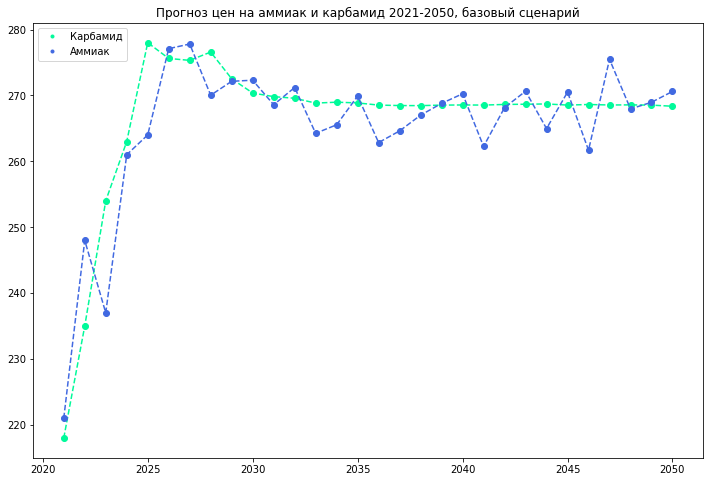

In [149]:
xs = forecast_horizon
ys = base_scenario_urea
yss = base_ammonia
plt.figure(figsize=(12, 8))
plt.title('Прогноз цен на аммиак и карбамид 2021-2050, базовый сценарий')

plt.plot(xs, ys, linestyle='--', marker='o', color='mediumspringgreen')
plt.plot(xs, yss, linestyle='--', marker='o', color='royalblue')
custom = [Line2D([], [], marker='.', color='mediumspringgreen', linestyle='None'),
          Line2D([], [], marker='.', color='royalblue', linestyle='None')]
plt.legend(custom, ['Карбамид', 'Аммиак'], loc='upper left');

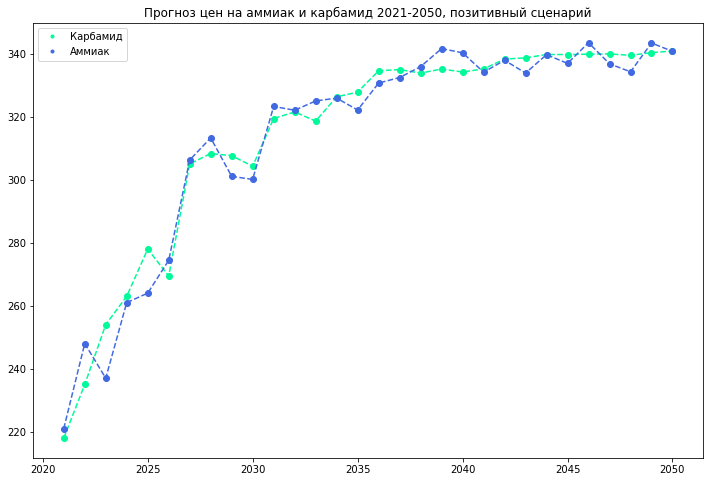

In [150]:
xs = forecast_horizon
ys = good_scenario_urea
yss = good_ammonia
plt.figure(figsize=(12, 8))
plt.title('Прогноз цен на аммиак и карбамид 2021-2050, позитивный сценарий')

plt.plot(xs, ys, linestyle='--', marker='o', color='mediumspringgreen')
plt.plot(xs, yss, linestyle='--', marker='o', color='royalblue')
custom = [Line2D([], [], marker='.', color='mediumspringgreen', linestyle='None'),
          Line2D([], [], marker='.', color='royalblue', linestyle='None')]
plt.legend(custom, ['Карбамид', 'Аммиак'], loc='upper left');

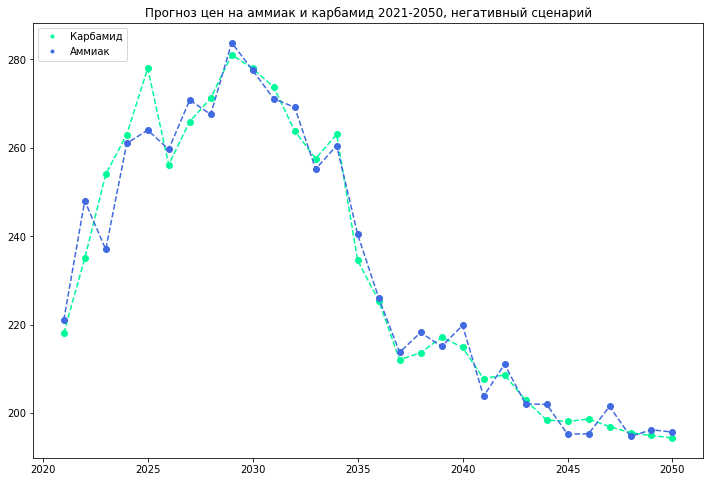

In [151]:
xs = forecast_horizon
ys = bad_scenario_urea
yss = bad_ammonia
plt.figure(figsize=(12, 8))
plt.title('Прогноз цен на аммиак и карбамид 2021-2050, негативный сценарий')

plt.plot(xs, ys, linestyle='--', marker='o', color='mediumspringgreen')
plt.plot(xs, yss, linestyle='--', marker='o', color='royalblue')
custom = [Line2D([], [], marker='.', color='mediumspringgreen', linestyle='None'),
          Line2D([], [], marker='.', color='royalblue', linestyle='None')]
plt.legend(custom, ['Карбамид', 'Аммиак'], loc='upper left');

# Прогноз цен по регионам: Азия, Северная Америка, Латинская Америка, Европа

In [163]:
data = pd.read_excel('Kearney_case.xlsx')

Выведем мировые цены на карбамид в январе 2021

In [198]:
world_price = float(data[data['Date'] == 'Jan 2021']['Urea price'])
world_price

265.0

Выведем цены на карбамид в азиатском, северо-американском, латино-американском, европейском регионах в январе 2021 

In [214]:
Asia_price = 316
North_Am_price = 278
Europe_price = 270
Latin_Am_price = 350

Посчитаем отклонение цен на карбамид в отдельном регионе от мировых в январе 2021

In [215]:
Asia_deviation = 1 + (Asia_price - world_price) / world_price
North_Am_deviation = 1 + (North_Am_price - world_price) / world_price 
Europe_deviation = 1 + (Europe_price - world_price) / world_price
Latin_Am_deviation = 1 + (Latin_Am_price - world_price) / world_price

__Выведем прогноз цен по регионам на карбамид__

При базовом сценарии

In [219]:
Asia_urea_base = Asia_deviation * base_scenario_urea
North_Am_urea_base = North_Am_deviation * base_scenario_urea
Europe_urea_base = Europe_deviation * base_scenario_urea
Latin_Am_urea_base = Latin_Am_deviation * base_scenario_urea

При положительном сценарии

In [225]:
Asia_urea_good = Asia_deviation * good_scenario_urea
North_Am_urea_good = North_Am_deviation * good_scenario_urea
Europe_urea_good = Europe_deviation * good_scenario_urea
Latin_Am_urea_good = Latin_Am_deviation * good_scenario_urea

При негативном сценарии

In [255]:
Asia_urea_bad = Asia_deviation * bad_scenario_urea
North_Am_urea_bad = North_Am_deviation * bad_scenario_urea
Europe_urea_bad = Europe_deviation * bad_scenario_urea
Latin_Am_urea_bad = Latin_Am_deviation * bad_scenario_urea

Цена на аммиак в Марокко для трех сценариев:

# Оценка инвестиционной привлекательности: NPV, IRR, PBP

Капитальные затраты - 1.530 млн. долл. США

In [393]:
capital_exp = 1530000000

Производительность завода, т/год

In [236]:
urea_annual = 1460000
ammonia_raw_annual = 1100000

__Для решения задачи выбора оптимального маршрута, решим уравнение:__


$$\frac{143}{66} \cdot x + 55000000 = \frac{294}{66} \cdot x,$$

где  x - количество тонн продукции, которое необходимо произвести, чтобы перевозка в порт Усть-Луга стала более выгодной, чем перевозка в порт Силламяэ,  143 и 294 - размеры тарифов в долларах США для обоих портов, 55 млн - капитальные затраты на расширение мощностей порта Усть-Луга  

Решением уравнения является:  $x = 2.40397 \cdot 10^7$ тонн

Известно, что для производства 1 тонны карбамида необходима 0.71 тонн аммиака. При условии, что для ЕвроХима приоритетным является производство карбамида, то количество ежегодно производимой конечной продукции, которая далее будет реализована по рыночной цене:

In [261]:
ammonia_annual = ammonia_raw_annual - 0.71 * urea_annual
total_annual = ammonia_annual + urea_annual
print(ammonia_annual, 'тонн аммиака в год')
print(urea_annual, 'тонн карбамида в год')
print(total_annual, 'всего тонн продукции в год')

63400.0 тонн аммиака в год
1460000 тонн карбамида в год
1523400.0 всего тонн продукции в год


In [300]:
round(2.40397 * 10 ** 7 / 1500000)

16

Таким образом, если завод будет работать в режиме проектных мощностей более 16 лет, то порт Усть-Луга при прочих равных обладает сравнительным примуществом по отношению к порту Силламяэ (меньшими постоянными и переменными издержками)

__Издержки завода__

Амортизация начисляется линейным способом в течение 25 лет, USD/год

In [307]:
Amort_annual = capital_exp / 25

Пошлины на ввоз в каждом регионе: на аммиак - 5.5%, на карбамид - 6.5% от цены

In [249]:
duty_urea = 0.065
duty_ammonia = 0.055

Налог на прибыль - 18%

In [250]:
income_tax = 0.18

Себестоимость производства аммиака - 139 USD/т, карбамида - 111 USD/т

In [339]:
urea_cost = 111
ammonia_cost = 139

Ставка дисконтирования - 11%

In [252]:
r = 0.11

Затраты на расширение мощностей порта Усть-Луга, распределенные на весь период

In [297]:
capacity_exp = 50000000

Затраты на логистику, USD/т:

In [299]:
tariff = 143 / 66
car_rental = 56 / 66
transshipment = 1.5
total_logistic = (tariff + car_rental + transshipment)
print(total_logistic, 'всего долларов на тонну на логистику')

4.515151515151516 всего долларов на тонну на логистику


При расчете размера фрахт использовалась предпосылка о том, что значение, приведенное в слайде рассчитывалось для 33 тонн груза (медианное значение)

In [301]:
braz_freicht = (40 + 60) * 0.5 / 33
china_freicht = (40 + 50) * 0.5 / 33
usa_freicht = (20 + 30) * 0.5 / 33
pol_freicht = (30 + 50) * 0.5 / 33

Условно-постоянные годовые административные расходы, USD/год

In [306]:
admin_exp_annual = 475000000 * 0.013

__Выручка завода__

Согласно, географии продаж: 

In [271]:
eu_share = 0.32
lat_share = 0.42
asia_share = 0.12
na_share = 0.04
other_share = 0.1

Завод выйдет на проектную мощность через год после даты окончания реализации, то есть в 2025 году, поэтому исключим из прогноза цены 2021 - 2024 гг.

In [277]:
asia_urea_base = Asia_urea_base[4:] 
na_urea_base = North_Am_urea_base[4:]
eu_urea_base = Europe_urea_base[4:]
lat_urea_base = Latin_Am_urea_base[4:]

asia_urea_good = Asia_urea_good[4:]
na_urea_good = North_Am_urea_good[4:]
eu_urea_good = Europe_urea_good[4:] 
lat_urea_good = Latin_Am_urea_good[4:]

asia_urea_bad = Asia_urea_bad[4:] 
na_urea_bad = North_Am_urea_bad[4:] 
eu_urea_bad = Europe_urea_bad[4:] 
lat_urea_bad = Latin_Am_urea_bad[4:] 

Посчитаем выручку завода для трех сценариев (взвешенная сумма * выпуск)

In [304]:
income_base = urea_annual * (asia_urea_base * asia_share + na_urea_base * na_share + eu_urea_base * eu_share \
+ lat_urea_base * lat_share + other_share * base_scenario_urea[4:]) + ammonia_annual * base_ammonia[4:]

income_good = urea_annual * (asia_urea_good * asia_share + na_urea_good * na_share + eu_urea_good * eu_share \
+ lat_urea_good * lat_share + other_share * good_scenario_urea[4:]) + ammonia_annual * good_ammonia[4:]

income_bad = urea_annual * (asia_urea_bad * asia_share + na_urea_bad * na_share + eu_urea_bad * eu_share \
+ lat_urea_bad * lat_share + other_share * bad_scenario_urea[4:]) + ammonia_annual * bad_ammonia[4:]

In [305]:
print('Выручка при базовом сценарии:', income_base, sep='\n')
print()
print('Выручка при позитивном сценарии:', income_good, sep='\n')
print()
print('Выручка при негативном сценарии:', income_bad, sep='\n')
print()

Выручка при базовом сценарии:
[4.92379669e+08 4.89113693e+08 4.88662205e+08 4.90328852e+08
 4.83522500e+08 4.79839180e+08 4.78661404e+08 4.78402179e+08
 4.76712986e+08 4.77025944e+08 4.77112806e+08 4.76101612e+08
 4.76093697e+08 4.76226031e+08 4.76473816e+08 4.76604093e+08
 4.76069255e+08 4.76604558e+08 4.76822599e+08 4.76532444e+08
 4.76591529e+08 4.76180559e+08 4.76930740e+08 4.76481415e+08
 4.76480777e+08 4.76296780e+08]

Выручка при позитивном сценарии:
[4.92379669e+08 4.78345285e+08 5.41289285e+08 5.47377555e+08
 5.45398831e+08 5.39635425e+08 5.67014297e+08 5.70515471e+08
 5.65727304e+08 5.78948944e+08 5.81291122e+08 5.93421451e+08
 5.94152607e+08 5.92502892e+08 5.95060920e+08 5.93351705e+08
 5.94649302e+08 6.00219787e+08 6.00645909e+08 6.02800447e+08
 6.02633753e+08 6.03241550e+08 6.02948288e+08 6.02026416e+08
 6.04093137e+08 6.04737504e+08]

Выручка при негативном сценарии:
[4.92379669e+08 4.54795636e+08 4.72158398e+08 4.80989217e+08
 4.98866637e+08 4.93145750e+08 4.85573952e+08

__Расчет NPV__

Расчитаем общие ежегодные издержки для 3 сценариев

In [394]:
annual_duty_base = 0.065 * urea_annual * (asia_urea_base * asia_share + na_urea_base * na_share + eu_urea_base * eu_share \
+ lat_urea_base * lat_share + other_share * base_scenario_urea[4:]) + 0.055 * ammonia_annual * base_ammonia[4:]

annual_duty_good = 0.065 * urea_annual * (asia_urea_good * asia_share + na_urea_good * na_share + eu_urea_good * eu_share \
+ lat_urea_good * lat_share + other_share * good_scenario_urea[4:]) + 0.055 * ammonia_annual * good_ammonia[4:]

annual_duty_bad = 0.065 * urea_annual * (asia_urea_bad * asia_share + na_urea_bad * na_share + eu_urea_bad * eu_share \
+ lat_urea_bad * lat_share + other_share * bad_scenario_urea[4:]) + 0.055 * ammonia_annual * bad_ammonia[4:]

annual_total_logistic = total_logistic * 1500000 + 23400 * (294 / 66 + total_logistic - tariff)  

annual_freicht = total_annual * (braz_freicht * lat_share + china_freicht * asia_share \
+ usa_freicht * na_share + pol_freicht * eu_share)

urea_cost_annual = urea_cost * urea_annual
ammonia_cost_annual = ammonia_cost * ammonia_annual

total_cost_annual_base = annual_duty_base + annual_total_logistic + annual_freicht \
+ urea_cost_annual + ammonia_cost_annual + Amort_annual + admin_exp_annual

total_cost_annual_good = annual_duty_good + annual_total_logistic + annual_freicht \
+ urea_cost_annual + ammonia_cost_annual + Amort_annual + admin_exp_annual

total_cost_annual_bad = annual_duty_bad + annual_total_logistic + annual_freicht \
+ urea_cost_annual + ammonia_cost_annual + Amort_annual + admin_exp_annual

Расчитаем NPV для 3 сценариев

In [399]:
npv_base = -(capital_exp + capacity_exp)
npv_good = -(capital_exp + capacity_exp)
npv_bad = -(capital_exp + capacity_exp)

for period in range(0, 25):
    gross_profit_base = income_base[period] - total_cost_annual_base[period]
    gross_profit_good = income_good[period] - total_cost_annual_good[period]
    gross_profit_bad = income_bad[period] - total_cost_annual_bad[period]
    
    npv_base = npv_base + gross_profit_base * (1 - income_tax) / (1 + r) ** (period + 1)
    npv_good = npv_good + gross_profit_good * (1 - income_tax) / (1 + r) ** (period + 1)
    npv_bad = npv_bad + gross_profit_bad * (1 - income_tax) / (1 + r) ** (period + 1)

In [400]:
npv_base

252917357.65432492

In [401]:
npv_good

705169038.2333113

In [490]:
npv_bad

8299841.6836934695

__Посмотрим, где функция NPV для трех сценариев меняет знак и найдем приблизительные значения IRR__

In [492]:
irr_base = 0.134
irr_good = 0.163
irr_bad = 0.112

__Вычислим срок PBP (срок окупаемости проекта)__

In [496]:
pbp_base = 0
pbp_good = 0
pbp_bad = 0

balance_base = -(capital_exp + capacity_exp)
balance_good = -(capital_exp + capacity_exp)
balance_bad = -(capital_exp + capacity_exp)
while True:
    balance_base = balance_base + (income_base[pbp_base] - total_cost_annual_base[pbp_base]) * (1 - income_tax) / (1 + r) ** (pbp_base + 1)
    if balance_base > 0:
        break
    pbp_base += 1

while True:
    balance_good = balance_good + (income_good[pbp_good] - total_cost_annual_good[pbp_good]) * (1 - income_tax) / (1 + r) ** (pbp_good + 1)
    if balance_good > 0:
        break
    pbp_good += 1

while True:
    balance_bad = balance_bad + (income_bad[pbp_bad] - total_cost_annual_bad[pbp_bad]) * (1 - income_tax) / (1 + r) ** (pbp_bad + 1)
    if balance_bad > 0:
        break
    pbp_bad += 1

In [497]:
pbp_base

15

In [498]:
pbp_good

10

In [499]:
pbp_bad

23